In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

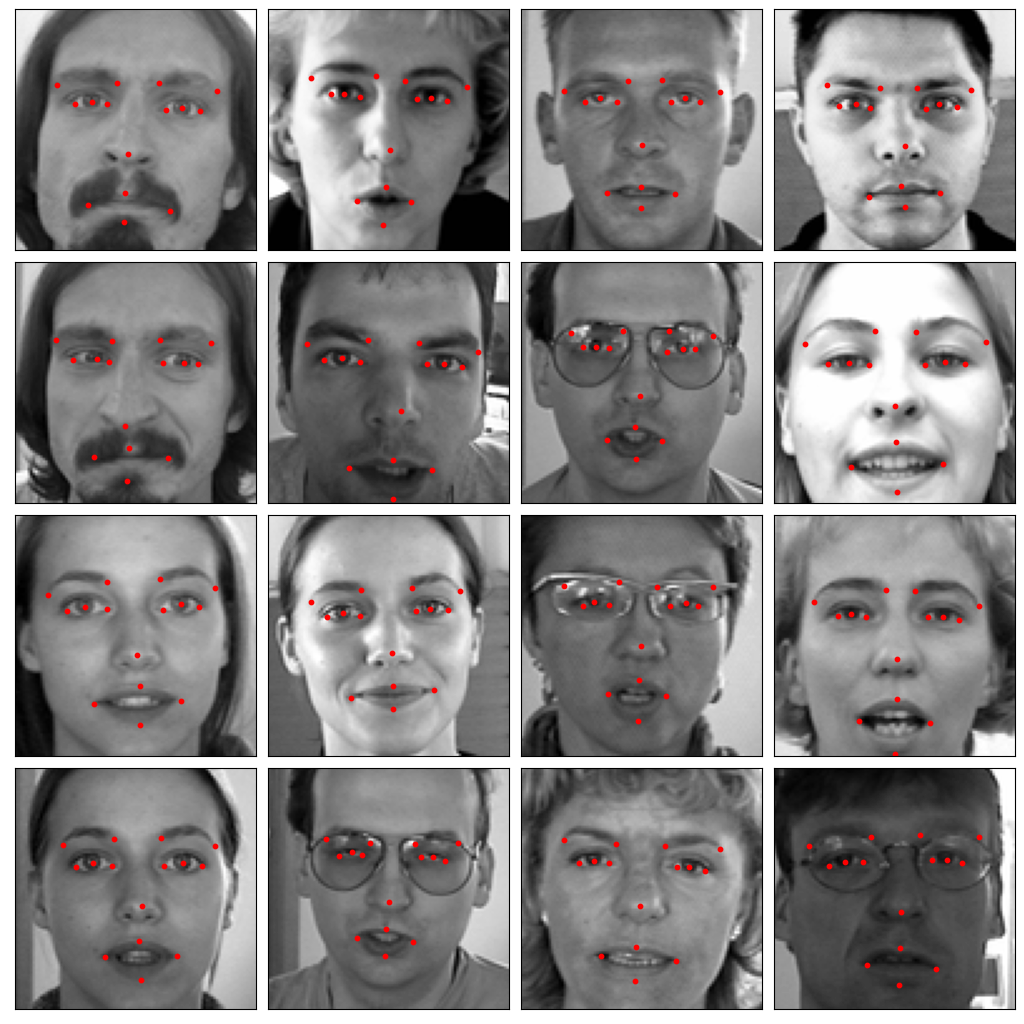

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_loss(y_pred, y_true, lamda):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

## L2 Loss

In [20]:
""" start training """
loss_function = l2_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 2925.2075  Validation Loss: 2093.7566  Best Validation Loss: 2093.7566
Epoch: 1 . Training Loss: 2085.5676  Validation Loss: 1717.7338  Best Validation Loss: 1717.7338
Epoch: 2 . Training Loss: 1725.5839  Validation Loss: 1408.919  Best Validation Loss: 1408.919
Epoch: 3 . Training Loss: 1405.7819  Validation Loss: 1143.8662  Best Validation Loss: 1143.8662
Epoch: 4 . Training Loss: 1123.6093  Validation Loss: 924.15967  Best Validation Loss: 924.15967
Epoch: 5 . Training Loss: 963.6293  Validation Loss: 753.85126  Best Validation Loss: 753.85126
Epoch: 6 . Training Loss: 755.67914  Validation Loss: 592.27765  Best Validation Loss: 592.27765
Epoch: 7 . Training Loss: 565.34973  Validation Loss: 460.5536  Best Validation Loss: 460.5536
Epoch: 8 . Training Loss: 467.88248  Validation Loss: 404.80203  Best Validation Loss: 404.80203
Epoch: 9 . Training Loss: 409.11478  Validation Loss: 355.39505  Best Validation Loss: 355.39505
Epoch: 10 . Training Loss: 328.0092

Epoch: 84 . Training Loss: 111.04466  Validation Loss: 114.52582  Best Validation Loss: 114.52582
Epoch: 85 . Training Loss: 103.319466  Validation Loss: 123.53768  Best Validation Loss: 114.52582
Epoch: 86 . Training Loss: 94.91321  Validation Loss: 114.08492  Best Validation Loss: 114.08492
Epoch: 87 . Training Loss: 115.24378  Validation Loss: 123.73985  Best Validation Loss: 114.08492
Epoch: 88 . Training Loss: 137.88672  Validation Loss: 151.56593  Best Validation Loss: 114.08492
Epoch: 89 . Training Loss: 138.67868  Validation Loss: 113.547935  Best Validation Loss: 113.547935
Epoch: 90 . Training Loss: 70.62826  Validation Loss: 136.95233  Best Validation Loss: 113.547935
Epoch: 91 . Training Loss: 121.12687  Validation Loss: 187.72093  Best Validation Loss: 113.547935
Epoch: 92 . Training Loss: 191.10219  Validation Loss: 113.30431  Best Validation Loss: 113.30431
Epoch: 93 . Training Loss: 137.70018  Validation Loss: 166.35312  Best Validation Loss: 113.30431
Epoch: 94 . Train

Epoch: 168 . Training Loss: 107.03403  Validation Loss: 103.35944  Best Validation Loss: 102.47331
Epoch: 169 . Training Loss: 112.826775  Validation Loss: 107.85485  Best Validation Loss: 102.47331
Epoch: 170 . Training Loss: 74.36624  Validation Loss: 106.39694  Best Validation Loss: 102.47331
Epoch: 171 . Training Loss: 79.174286  Validation Loss: 102.07506  Best Validation Loss: 102.07506
Epoch: 172 . Training Loss: 97.650665  Validation Loss: 101.169876  Best Validation Loss: 101.169876
Epoch: 173 . Training Loss: 83.10284  Validation Loss: 99.69373  Best Validation Loss: 99.69373
Epoch: 174 . Training Loss: 81.36977  Validation Loss: 99.61774  Best Validation Loss: 99.61774
Epoch: 175 . Training Loss: 61.418774  Validation Loss: 99.70717  Best Validation Loss: 99.61774
Epoch: 176 . Training Loss: 104.09788  Validation Loss: 99.490364  Best Validation Loss: 99.490364
Epoch: 177 . Training Loss: 108.95954  Validation Loss: 103.72538  Best Validation Loss: 99.490364
Epoch: 178 . Tra

Epoch: 253 . Training Loss: 47.435703  Validation Loss: 87.783035  Best Validation Loss: 86.6194
Epoch: 254 . Training Loss: 79.72804  Validation Loss: 87.22841  Best Validation Loss: 86.6194
Epoch: 255 . Training Loss: 91.92827  Validation Loss: 86.87882  Best Validation Loss: 86.6194
Epoch: 256 . Training Loss: 93.440674  Validation Loss: 89.44042  Best Validation Loss: 86.6194
Epoch: 257 . Training Loss: 77.30791  Validation Loss: 84.76662  Best Validation Loss: 84.76662
Epoch: 258 . Training Loss: 86.976166  Validation Loss: 86.506775  Best Validation Loss: 84.76662
Epoch: 259 . Training Loss: 86.22622  Validation Loss: 86.12716  Best Validation Loss: 84.76662
Epoch: 260 . Training Loss: 73.51751  Validation Loss: 84.17292  Best Validation Loss: 84.17292
Epoch: 261 . Training Loss: 66.32792  Validation Loss: 88.21042  Best Validation Loss: 84.17292
Epoch: 262 . Training Loss: 83.12329  Validation Loss: 93.696045  Best Validation Loss: 84.17292
Epoch: 263 . Training Loss: 70.08682  

Epoch: 338 . Training Loss: 57.44423  Validation Loss: 75.92066  Best Validation Loss: 72.94372
Epoch: 339 . Training Loss: 66.13918  Validation Loss: 76.08247  Best Validation Loss: 72.94372
Epoch: 340 . Training Loss: 55.548344  Validation Loss: 72.42292  Best Validation Loss: 72.42292
Epoch: 341 . Training Loss: 70.62927  Validation Loss: 74.502235  Best Validation Loss: 72.42292
Epoch: 342 . Training Loss: 59.29657  Validation Loss: 77.57404  Best Validation Loss: 72.42292
Epoch: 343 . Training Loss: 70.441216  Validation Loss: 76.37033  Best Validation Loss: 72.42292
Epoch: 344 . Training Loss: 69.90866  Validation Loss: 73.495415  Best Validation Loss: 72.42292
Epoch: 345 . Training Loss: 51.080364  Validation Loss: 74.81407  Best Validation Loss: 72.42292
Epoch: 346 . Training Loss: 58.026794  Validation Loss: 75.49451  Best Validation Loss: 72.42292
Epoch: 347 . Training Loss: 42.592373  Validation Loss: 74.16541  Best Validation Loss: 72.42292
Epoch: 348 . Training Loss: 71.21

Epoch: 423 . Training Loss: 43.04254  Validation Loss: 64.866066  Best Validation Loss: 64.41068
Epoch: 424 . Training Loss: 35.437496  Validation Loss: 64.17629  Best Validation Loss: 64.17629
Epoch: 425 . Training Loss: 48.221542  Validation Loss: 63.83567  Best Validation Loss: 63.83567
Epoch: 426 . Training Loss: 52.07394  Validation Loss: 63.819782  Best Validation Loss: 63.819782
Epoch: 427 . Training Loss: 41.91315  Validation Loss: 63.3526  Best Validation Loss: 63.3526
Epoch: 428 . Training Loss: 66.84938  Validation Loss: 63.633682  Best Validation Loss: 63.3526
Epoch: 429 . Training Loss: 46.34191  Validation Loss: 65.70857  Best Validation Loss: 63.3526
Epoch: 430 . Training Loss: 41.663715  Validation Loss: 66.85771  Best Validation Loss: 63.3526
Epoch: 431 . Training Loss: 39.237785  Validation Loss: 64.90561  Best Validation Loss: 63.3526
Epoch: 432 . Training Loss: 38.201317  Validation Loss: 68.32871  Best Validation Loss: 63.3526
Epoch: 433 . Training Loss: 38.34621  

Epoch: 508 . Training Loss: 60.81389  Validation Loss: 58.74125  Best Validation Loss: 58.175877
Epoch: 509 . Training Loss: 39.77022  Validation Loss: 59.385666  Best Validation Loss: 58.175877
Epoch: 510 . Training Loss: 47.633602  Validation Loss: 66.15118  Best Validation Loss: 58.175877
Epoch: 511 . Training Loss: 39.032207  Validation Loss: 66.63294  Best Validation Loss: 58.175877
Epoch: 512 . Training Loss: 38.1506  Validation Loss: 60.36323  Best Validation Loss: 58.175877
Epoch: 513 . Training Loss: 37.626865  Validation Loss: 70.384415  Best Validation Loss: 58.175877
Epoch: 514 . Training Loss: 39.042236  Validation Loss: 71.15822  Best Validation Loss: 58.175877
Epoch: 515 . Training Loss: 51.186096  Validation Loss: 60.930794  Best Validation Loss: 58.175877
Epoch: 516 . Training Loss: 41.64461  Validation Loss: 73.11026  Best Validation Loss: 58.175877
Epoch: 517 . Training Loss: 42.316242  Validation Loss: 90.01918  Best Validation Loss: 58.175877
Epoch: 518 . Training 

Epoch: 592 . Training Loss: 28.995068  Validation Loss: 54.767506  Best Validation Loss: 52.290848
Epoch: 593 . Training Loss: 24.074797  Validation Loss: 69.22939  Best Validation Loss: 52.290848
Epoch: 594 . Training Loss: 40.51927  Validation Loss: 65.11652  Best Validation Loss: 52.290848
Epoch: 595 . Training Loss: 57.380047  Validation Loss: 57.149727  Best Validation Loss: 52.290848
Epoch: 596 . Training Loss: 34.115543  Validation Loss: 73.03269  Best Validation Loss: 52.290848
Epoch: 597 . Training Loss: 56.968784  Validation Loss: 58.109093  Best Validation Loss: 52.290848
Epoch: 598 . Training Loss: 33.629562  Validation Loss: 63.36578  Best Validation Loss: 52.290848
Epoch: 599 . Training Loss: 42.479343  Validation Loss: 75.83994  Best Validation Loss: 52.290848
Epoch: 600 . Training Loss: 73.91192  Validation Loss: 55.81029  Best Validation Loss: 52.290848
Epoch: 601 . Training Loss: 29.17827  Validation Loss: 57.575657  Best Validation Loss: 52.290848
Epoch: 602 . Traini

Epoch: 676 . Training Loss: 23.451962  Validation Loss: 49.56343  Best Validation Loss: 47.981083
Epoch: 677 . Training Loss: 37.027073  Validation Loss: 53.391697  Best Validation Loss: 47.981083
Epoch: 678 . Training Loss: 29.680178  Validation Loss: 82.54818  Best Validation Loss: 47.981083
Epoch: 679 . Training Loss: 43.655205  Validation Loss: 72.03334  Best Validation Loss: 47.981083
Epoch: 680 . Training Loss: 48.013355  Validation Loss: 48.74256  Best Validation Loss: 47.981083
Epoch: 681 . Training Loss: 35.820637  Validation Loss: 61.07501  Best Validation Loss: 47.981083
Epoch: 682 . Training Loss: 37.186184  Validation Loss: 53.542164  Best Validation Loss: 47.981083
Epoch: 683 . Training Loss: 26.207052  Validation Loss: 49.907593  Best Validation Loss: 47.981083
Epoch: 684 . Training Loss: 25.3401  Validation Loss: 71.63769  Best Validation Loss: 47.981083
Epoch: 685 . Training Loss: 45.59792  Validation Loss: 54.47349  Best Validation Loss: 47.981083
Epoch: 686 . Trainin

### visualization loss

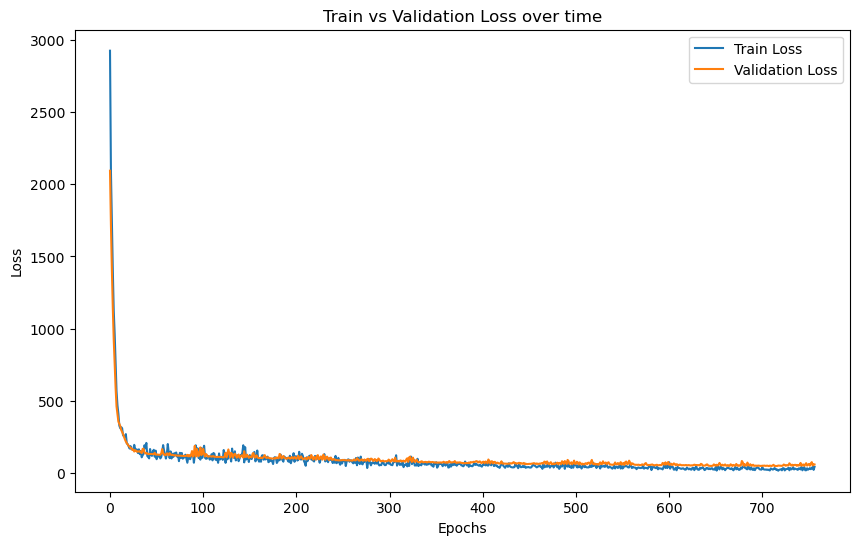

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("MSE: ", l2_loss(test_true, test_pred).numpy())

MSE:  45.57488


### visualize result

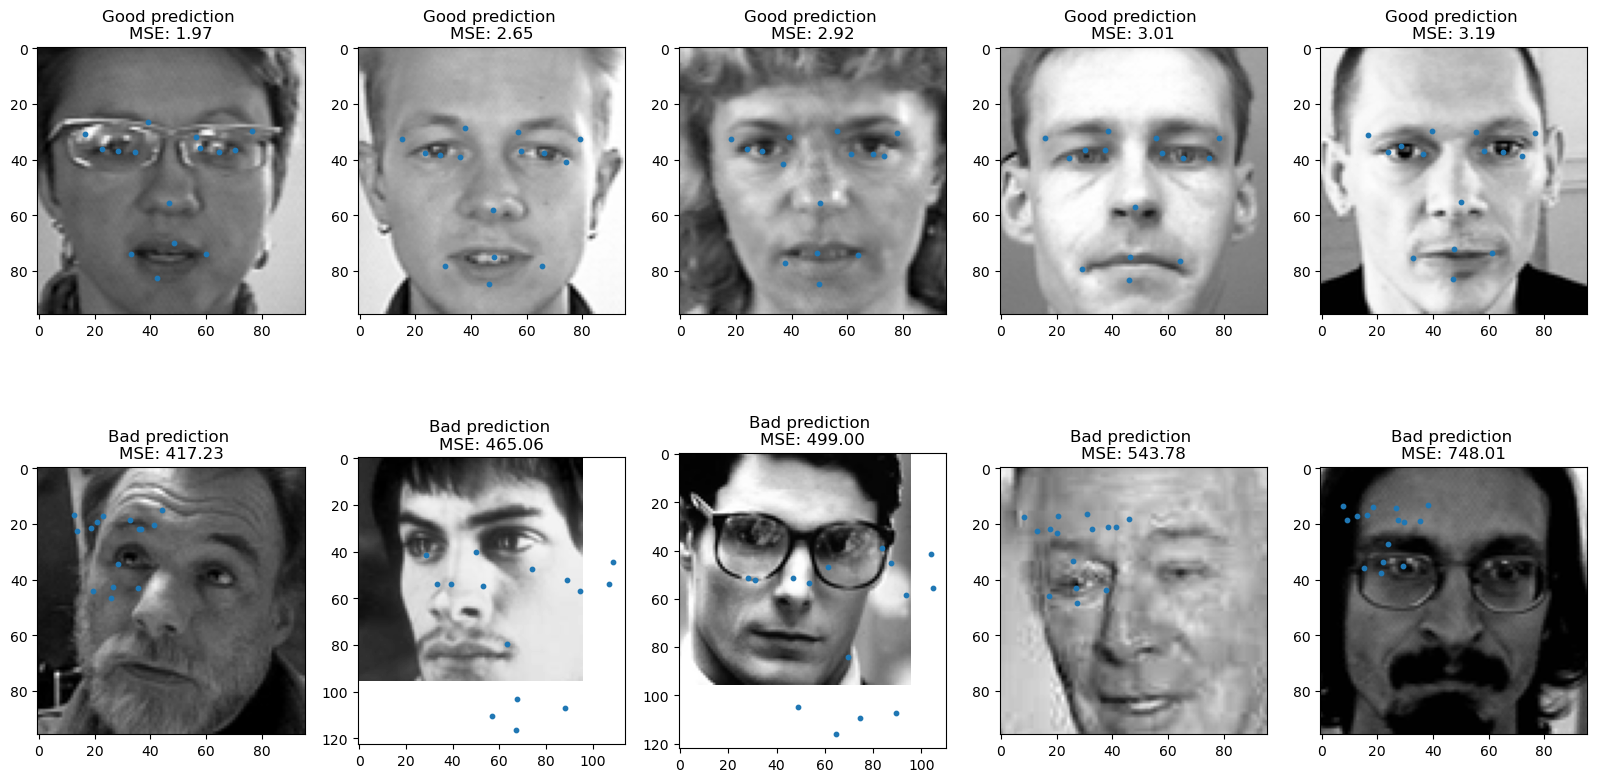

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.square(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nMSE: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nMSE: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
